### The Bayesian landscape

When we setup a Bayesian inference problem with N unknowns, we are implicitly creating an N dimensional space for the prior distributions to exist in. Associated with the space is an additional dimension, which we can describe as *surface*, or *curve* that sits on top of the space, that reflects the *prior probability* of a particular point. The surface is defined by the prior distributions.

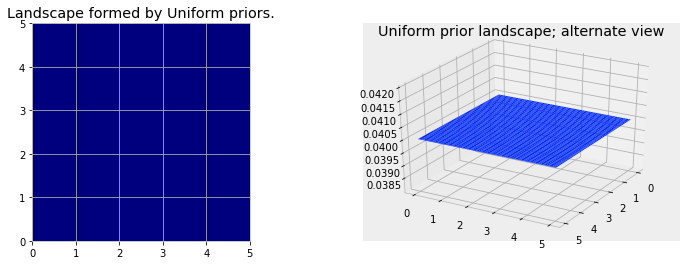

In [11]:
from mpl_toolkits.mplot3d import Axes3D

figsize(12.5, 4)

jet = plt.cm.jet
fig = plt.figure()
x = y = np.linspace(0, 5, 100)
X, Y = np.meshgrid(x, y)

plt.subplot(121)
uni_x = stats.uniform.pdf(x, loc=0, scale=5)
uni_y = stats.uniform.pdf(y, loc=0, scale=5)
M = np.dot(uni_y[:,None], uni_x[None,:])
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet, vmax=1, vmin=.15,extent=(0,5,0,5))
plt.xlim(0,5)
plt.ylim(0,5)
plt.title('Landscape formed by Uniform priors.')

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(X, Y, M, cmap=plt.cm.jet, vmax=1, vmin=-.15)
ax.view_init(azim=390)
plt.title('Uniform prior landscape; alternate view')

If the two priors are $\text{Exp }(3)$ and $\text{Exp }(10)$, then the space is all positive numbers on the 2-D plane, and the surface induced by the priors looks like a water fall that starts at the point (0, 0) and flows over the positive numbers.

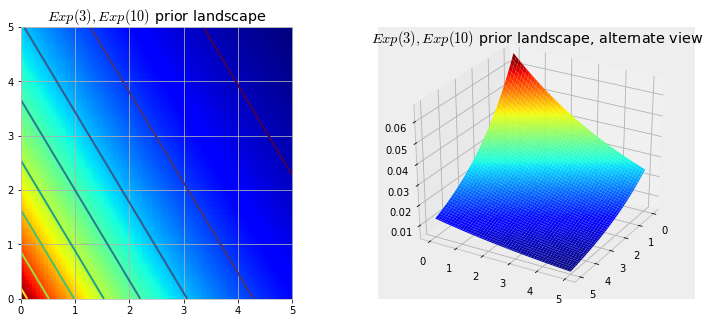

In [16]:
figsize(12.5, 5)
fig = plt.figure()
plt.subplot(121)

exp_x = stats.expon.pdf(x, scale=3)
exp_y = stats.expon.pdf(x, scale=5)
M = np.dot(exp_y[:,None], exp_x[None,:])
CS = plt.contour(X,Y,M)
im = plt.imshow(M, interpolation='none', origin='lower', cmap=jet, extent=(0,5,0,5))

plt.title('$Exp(3), Exp(10)$ prior landscape')

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(X, Y, M, cmap=jet)
ax.view_init(azim=390)
plt.title('$Exp(3), Exp(10)$ prior landscape, alternate view')

If these surfaces describe our *prior distributions* on the unknowns, what happens to our space after we incorporate our observed data $X$? The data $X$ does not change the space, but it changes the surface of the space by *pulling* and *stretching* the fabric of the prior surface to reflect where the true parameters likely live. More data means more pulling and stretching, and our original shape becomes mangled or insignificant compared to the newly formed shape. Less data, and our original shape is more present. Regardless, the resulting surface describes the *posterior distribution*

In [32]:
# create the observed data

# sample size of data we observe, trying varying this (keep it less than 100 ;)
N = 5

# the true parameters, but of course we do not see these values...
lambda_1_true = 1
lambda_2_true = 3

#...we see the data generated, dependent on the above two values.
data = np.concatenate([
    stats.poisson.rvs(lambda_1_true, size=(N, 1)),
    stats.poisson.rvs(lambda_2_true, size=(N, 1))
], axis=1)
print("observed (2-dimensional,sample size = %d):" % N, data)

# plotting details.
x = y = np.linspace(.01, 5, 100)
likelihood_x = np.array([stats.poisson.pmf(data[:, 0], _x)
                        for _x in x]).prod(axis=1)
likelihood_y = np.array([stats.poisson.pmf(data[:, 1], _y)
                        for _y in y]).prod(axis=1)
L = np.dot(likelihood_x[:, None], likelihood_y[None, :])

observed (2-dimensional,sample size = 5): [[2 2]
 [0 3]
 [4 3]
 [1 1]
 [1 4]]


(0, 5)

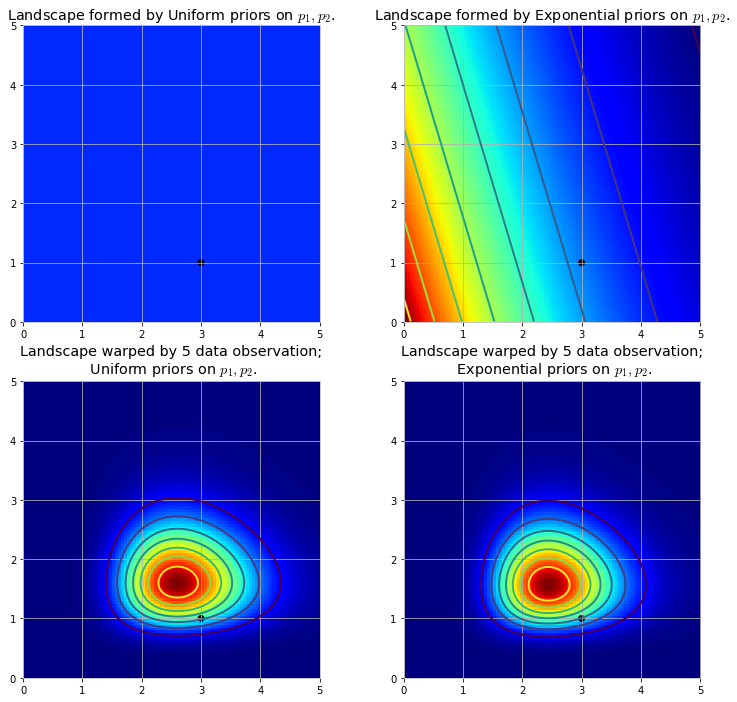

In [33]:
figsize(12.5, 12)
# matplotlib heavy lifting below, beware!
plt.subplot(221)
uni_x = stats.uniform.pdf(x, loc=0, scale=5)
uni_y = stats.uniform.pdf(x, loc=0, scale=5)
M = np.dot(uni_y[:, None], uni_x[None, :])
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet, vmax=1, vmin=-.15, extent=(0, 5, 0, 5))
plt.scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolor="none")
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.title("Landscape formed by Uniform priors on $p_1, p_2$.")

plt.subplot(223)
plt.contour(x, y, M * L)
im = plt.imshow(M * L, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5))
plt.title("Landscape warped by %d data observation;\n Uniform priors on $p_1, p_2$." % N)
plt.scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolor="none")
plt.xlim(0, 5)
plt.ylim(0, 5)

plt.subplot(222)
exp_x = stats.expon.pdf(x, loc=0, scale=3)
exp_y = stats.expon.pdf(x, loc=0, scale=10)
M = np.dot(exp_y[:, None], exp_x[None, :])

plt.contour(x, y, M)
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5))
plt.scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolor="none")
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.title("Landscape formed by Exponential priors on $p_1, p_2$.")

plt.subplot(224)
# This is the likelihood times prior, that results in the posterior.
plt.contour(x, y, M * L)
im = plt.imshow(M * L, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5))

plt.scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolor="none")
plt.title("Landscape warped by %d data observation;\n Exponential priors on \
$p_1, p_2$." % N)
plt.xlim(0, 5)
plt.ylim(0, 5)

### Exploring the landscape using the MCMC

The idea behind MCMC í to perform an intelligent search of the space. To say "search" implies we are looking for a particular point, which is perhaps not an accurate as we are really looking for a broad mountain.

MCMC returns *samples* from the posterior distribution. MCMC performs a task similar to repeatedly asking "How likely is this pebble I found to be from the mountain I am searching for?", and completes its task by returning thounsands of accepted pebbles in hopes of reconstructing the original mountain. In MCMC and PyMC lingo, the returned sequence of "pebbles" are the samples, cumulatively called the *traces*.

MCMC intelligently searches and hopefully converge towards the areas of high posterior probability. MCMC does this by exploring nearby positions and moving into areas with higher probability. MCMC moves towards a *borader area* in the space and randomly walks in that area, picking up samples from that area.

### Algorithms to perform MCMC

1. Start at current position.
2. Propose moving to a new position
3. Accept/Reject the new position based on the position's adherence to the data and prior distributions (ask if the pebble likely came from the mountain)
4. A. If you accept: Move to the new position. Return to step 1
   B. Else: Do not move to new position. Return to Step 1.
5. After a large number of interations, return all accepted positions.

This way we move in the general direction towards the regions where the posterior distributions exist, and collect samples sparingly on the journey. Once we reach the posterior distribution, we can easily collect samples as they likely all belong to the posterior distribution.

If the current position of the MCMC algorithm is in an area of extremely low probability, which is often the case when the algorithm begins (typically at a random location in the space), the algorithm will move in positions that *are likely not from the posterior* but better than everything else nearby.

### Other approximation solutions to the posterior

* Laplace approximation
* Variational Bayes
* Traditional MCMC

##### Example: Unsupervised Clustering using a Mixture Model

Suppose we are given the following dataset:

[ 115.85679142  152.26153716  178.87449059  162.93500815  107.02820697
  105.19141146  118.38288501  125.3769803   102.88054011  206.71326136] ...


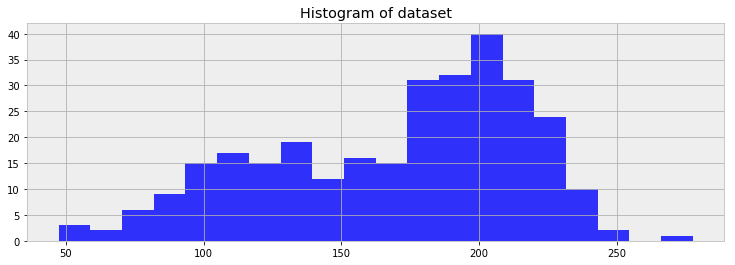

In [36]:
figsize(12.5, 4)

data = np.loadtxt('data/mixture_data.csv', delimiter=',')

plt.hist(data, bins=20, color="b", histtype="stepfilled", alpha=0.8)
plt.title('Histogram of dataset')
plt.ylim(0, None)
print(data[:10], '...')

It appears the data has a bimodal form, that is, it appears to have two peaks. Perhaps there are two clusters within this dataset.

We can propose the following data generation algorithm

1. For each data point, choose cluster 1 with probability $p$, else choose cluster 2.
2. Draw a random variate from a Normal distribution with parameters $\mu_i$ and $\sigma_i$ where $i$ was chosen in step 1.
3. Repeat.

Denote the Normal Distribution $Nor_0$ and $Nor_1$. Both currently have unknown mean and standard deviation, denoted $\mu_i$ and $\sigma_i, i = 0,1$

An appropriate way to assign data points to clusters is to use a PyMC Categorical stochastic variable. Its parameter is a $k$-length array of probabilities that must sum to one and its value attribute is a integer between 0 and k-1 randomly chosen according to the crafted array of probabilities. A *priori*, we do not know that the probability of assignment to cluster 1, so we create a uniform variable over 0, 1 to model this.

PyMC3 uses Theano under the hood to construct the models so we need to use *theano.tensor.stack()* to combine $p_1$ and $p_2$ into a vector that it can understand. 

In [46]:
import theano.tensor as T

with pm.Model() as model:
    p1 = pm.Uniform('p', 0, 1)
    p2 = 1 - p1
    p = T.stack([p1, p2])   
    assignment = pm.Categorical("assignment", p, shape=data.shape[0],
                                testval=np.random.randint(0, 2, data.shape[0]))
    print("Prior assignment, with p = {}".format(p1.tag.test_value))
    print(assignment.tag.test_value[:10], "...")

Prior assignment, with p = 0.5
[1 1 0 1 1 1 1 0 1 1] ...


The standard deviations of the two Normals are different. To maintain ignorance of what the standard deviations might be, we will initially model them as uniform on 0 to 100. We will include both standard deviations in our model using a single line of PyMC3 code:

*sds = pm.Uniform("sds", 0, 100, shape=2)*

We also need to specify priors on the centers of the clusters. The centers are really the $\mu$ parameters in these Normal distributions. Their priors can be modeled by a Normal distribution.

In [47]:
with model:
    sds = pm.Uniform("sds", 0, 100, shape=2)
    centers = pm.Normal("centers",
                        mu=np.array([120, 190]),
                        sd = np.array([10, 10]),
                        shape=2)
    center_i = pm.Deterministic("center_i", centers[assignment])
    sd_i = pm.Deterministic("sd_i", sds[assignment])
    
    # and to combine it with the observation
    observations = pm.Normal("obs", mu=center_i, sd=sd_i, observed=data)
    
print("Random assignments: ", assignment.tag.test_value[:4], "...")
print("Assigned center: ", center_i.tag.test_value[:4], "...")
print("Assigned standard deviation: ", sd_i.tag.test_value[:4], "...")

Random assignments:  [1 1 0 1] ...
Assigned center:  [ 190.  190.  120.  190.] ...
Assigned standard deviation:  [ 50.  50.  50.  50.] ...


We add the variables that we create to our model. AS long as we work within this context we will be working with the same variables that we have already defined. We will tell our model to explore the space that we have so far defined by defining the sampling methods (*Metropolis()* and *ElemwiseCategorical()*). We will use these sampling methods together to explore the space by using *sample(iterations, step)*, where *iteration* is the number of steps you wish the algorithm to perform and *step* is the way in which you want to handle those steps.

In [50]:
with model:
    step1 = pm.Metropolis(vars=[p, sds, centers])
    step2 = pm.ElemwiseCategorical(vars=[assignment])
    trace = pm.sample(25000, step=[step1, step2])

C:\Users\habui\.conda\envs\mcmc\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: ElemwiseCategorical is deprecated, switch to CategoricalGibbsMetropolis.
  This is separate from the ipykernel package so we can avoid doing imports until
100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 25000/25000 [01:42<00:00, 244.20it/s]


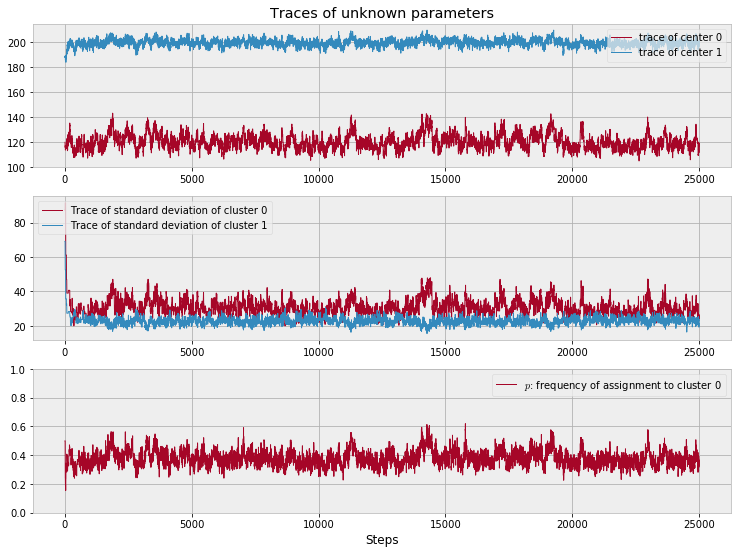

In [54]:
figsize(12.5, 9)
plt.subplot(311)
lw = 1
centers_trace = trace["centers"]

colors = ["#348ABD", "#A60628"] if centers_trace[-1, 0] > center_trace[-1, 1] \
    else ["#A60628", "#348ABD"]
plt.plot(centers_trace[:, 0], label="trace of center 0", c=colors[0], lw=lw)
plt.plot(centers_trace[:, 1], label="trace of center 1", c=colors[1], lw=lw)
plt.title("Traces of unknown parameters")
leg = plt.legend(loc="upper right")
leg.get_frame().set_alpha(0.7)

plt.subplot(312)
std_trace = trace["sds"]
plt.plot(std_trace[:, 0], label="Trace of standard deviation of cluster 0", 
         c=colors[0], lw=lw)
plt.plot(std_trace[:, 1], label="Trace of standard deviation of cluster 1", 
         c=colors[1], lw=lw)
leg = plt.legend(loc="upper left")

plt.subplot(313)
p_trace = trace["p"]
plt.plot(p_trace, label="$p$: frequency of assignment to cluster 0",
     color=colors[0], lw=lw)
plt.xlabel("Steps")
plt.ylim(0, 1)
plt.legend();

Notice the following charateristics:
1. The traces converges, not to a single point, but to a distribution of possible points. This is *convergence* in an MCMC algorithm.
2. Inference using the first few thousand points is a bad idea, as they are unrelated to the final distribution we are interested in. Thus it is a good idea to discard those samples before using the samples for interfence. We call this period before converge the *burn-in* period.
3. The traces appear as a random "walk" around the space, that is, the paths exhibit correlation with previous positions. This is both good and bad. We will always have correlation between current positions and the previous positions, but too much of it means we are not exploring the space well. 

To achieve further convergence, we will perform more MCMC steps. To continue where we left off, we pass the *trace* that we have already stored into the *sample()* function with the same step value.

We will sample the MCMC 50000 more times and visualize the progress below:

In [55]:
with model:
    trace = pm.sample(50000, step = [step1, step2], trace=trace)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [03:25<00:00, 242.75it/s]


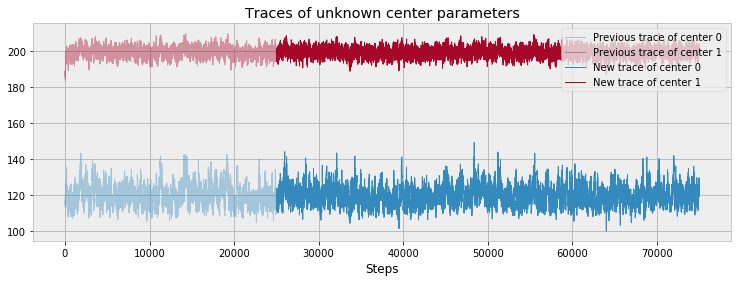

In [58]:
figsize(12.5, 4)
center_trace = trace['centers'][25000:]
prev_center_trace = trace['centers'][:25000]

x = np.arange(25000)
plt.plot(x, prev_center_trace[:,0], label="Previous trace of center 0",
         lw=lw, alpha=0.4, c=colors[1])
plt.plot(x, prev_center_trace[:,1], label="Previous trace of center 1",
         lw=lw, alpha=0.4, c=colors[0])

x = np.arange(25000, 75000)
plt.plot(x, center_trace[:,0], label="New trace of center 0", lw=lw, c=colors[1])
plt.plot(x, center_trace[:,1], label="New trace of center 1", lw=lw, c=colors[0])

plt.title('Traces of unknown center parameters')
leg = plt.legend(loc="upper right")
leg.get_frame().set_alpha(0.8)
plt.xlabel("Steps")

#### Cluster Investigation

We have not forgotten our main challenge: identify the clusters. We have determined posterior distributions for our unknowns. We plot the posterior distributions of the center and standard deviation variables below:

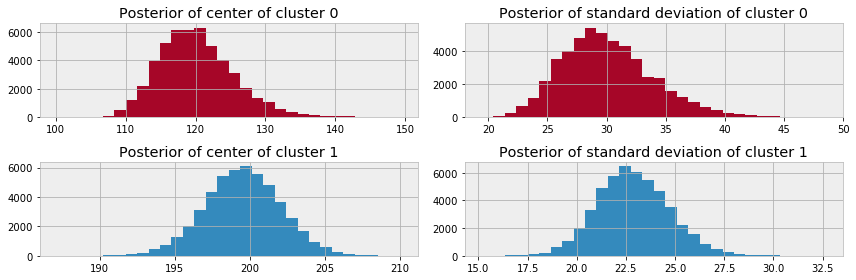

In [59]:
figsize(12,4)
std_trace = trace["sds"][25000:]
prev_std_trace = trace["sds"][:25000]

_i = [1,2,3,4]
for i in range(2):
    plt.subplot(2, 2, _i[2*i])
    plt.title("Posterior of center of cluster {}".format(i))
    plt.hist(center_trace[:,i], color=colors[i], bins=30, histtype="stepfilled")
    
    plt.subplot(2, 2, _i[2*i+1])
    plt.title("Posterior of standard deviation of cluster {}".format(i))
    plt.hist(std_trace[:,i], color=colors[i], bins=30, histtype="stepfilled")
    
plt.tight_layout()

The MCMC algorithm proposed that the most likely centers of the two clusters are near 120 and 200.

We are also given the posterior distributions for the labels of the data point, which is present in *trace["assignment"]*. Below is a visualization of this. The y-axis represents a subsample of the posterior labels for each data point. The x-axis are the sorted values of the data points. A red square is an assignment to cluster 1, and a blue square is an assignment to cluster 0.

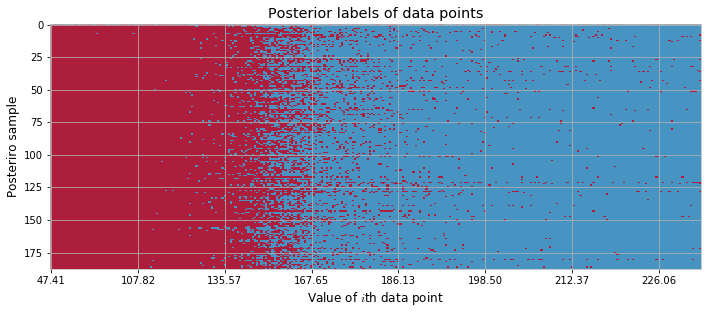

In [64]:
import matplotlib as mpl

figsize(12.5, 4.5)
plt.cmap = mpl.colors.ListedColormap(colors)
plt.imshow(trace["assignment"][::400, np.argsort(data)],
           cmap=plt.cmap, aspect=.6, alpha=.9)
plt.xticks(np.arange(0, data.shape[0], 40),
          ["%.2f" % s for s in np.sort(data)[::40]])
plt.ylabel("Posteriro sample")
plt.xlabel("Value of $i$th data point")
plt.title("Posterior labels of data points")

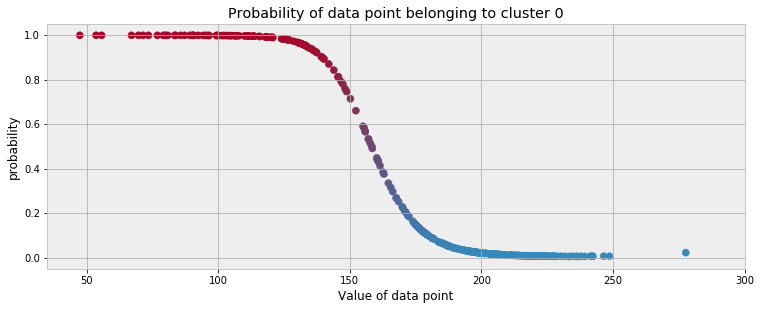

In [68]:
cmap = mpl.colors.LinearSegmentedColormap.from_list("BMH", colors)
assign_trace = trace["assignment"]
plt.scatter(data, 1 - assign_trace.mean(axis=0), cmap=cmap, 
            c=assign_trace.mean(axis=0), s = 50)
plt.ylim(-0.05, 1.05)
plt.xlim(35, 300)
plt.title("Probability of data point belonging to cluster 0")
plt.ylabel("probability")
plt.xlabel("Value of data point")

Even though we modeled the clusters using Normal distributions, we didn't get just a single Normal distribution that *best* fits the data (whatever our definition of best is), but a distribution of values for Normal's parameters. How can we choose just a single pair of values for the mean and variance and determine a *sorta-best-fit* gaussian?

We could use the *mean* of the posterior distributions. Below we overlay the Normal density functions, using the mean of the posterior distributions as the chosen parameters with our observed data:

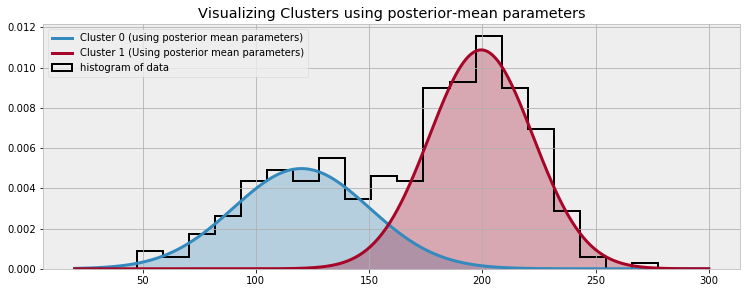

In [72]:
norm = stats.norm
x = np.linspace(20, 300, 500)
posterior_center_means = center_trace.mean(axis=0)
posterior_std_means = std_trace.mean(axis=0)
posterior_p_mean = trace["p"].mean()

plt.hist(data, bins=20, histtype="step", normed=True, color="k", lw=2, 
         label="histogram of data")
y = posterior_p_mean * norm.pdf(x, loc=posterior_center_means[0], 
                              scale=posterior_std_means[0])
plt.plot(x, y, label="Cluster 0 (using posterior mean parameters)", lw=3)
plt.fill_between(x, y, color=colors[1], alpha=0.3)

y = (1 - posterior_p_mean) * norm.pdf(x, loc=posterior_center_means[1],
                                      scale=posterior_std_means[1])
plt.plot(x, y, label="Cluster 1 (Using posterior mean parameters)", lw=3)
plt.fill_between(x, y, color=colors[0], alpha=0.3)

plt.legend(loc="upper left")
plt.title("Visualizing Clusters using posterior-mean parameters")

### Clustering: Prediction

Suppose we observe a new data point, say $x = 175$, and we wish to label it to a cluster. It is foolish to simply assign it to the *closer* cluster center, as this ignores the standard deviation of the clusters, and we have seen from the plots above that this consideration is very important. More formally: we are interested in the *probability* (as we cannot be certain about labels) of assigning $x = 175$ to cluster 1. Denote the assignment of $x$ as $L_x$, which is equal to 0 or 1, and we are interested in $P(L_x = 1 | x = 175)$

We can re-run the above MCMC with the additional data point appended. The disadvantage with this method is that it will be slow to infer for each novel data point. Alternatively, we can try a *less precise*, but much quicker method.

We will use *Bayes Theoreom* for this.

$$ P(A|X) = \frac{P(X|A)P(A)}{P(X)}$$

In our case, A represents $L_x = 1$ and $X$ is the evidence we have: we observe that $x = 175$. For a particular sample set of parameters for our posterior distribution, $(\mu_0, \sigma_0, \mu_1, \sigma_1)$, we are interested in asking "Is the probability that $x$ is in cluster 1 **greater** than the probability it is in cluster 0?".

$$
\begin{align}
& P(L_x = 1 | x = 175) > P(L_x = 0 | x = 175) \\\\
& P(x = 175 | L_x = 1)P(L_x = 1) > P(x = 175 | L_x = 0)P(L_x = 0)
\end{align}
$$

In [75]:
norm_pdf = stats.norm.pdf
p_trace = trace["p"][25000:]
prev_p_trace = trace["p"][:25000]
x = 175

v = p_trace * norm_pdf(x, loc=center_trace[:, 0], scale=std_trace[:, 0]) > \
    (1 - p_trace) * norm_pdf(x, loc=center_trace[:, 1], scale=std_trace[:, 1])
    
print("Probability of belonging to cluster 1: ", v.mean())

Probability of belonging to cluster 1:  0.0075


Giving us a probability instead of a label is a very useful thing. Instead of the naive

$$ L = 1 \text{ if prob } > 0.5 \text{ else } 0$$

we can optimize our guesses using a *loss function*.

### Using MAP to improve convergence

The MCMC result might be more scattered, or perhaps less scattered. The problem is that our traces are a function of the **starting values** of the MCMC algorithm.

Letting MCMCM run long enough, the algorithm *should forget its initial position*. in fact, this is what it means to say the MCMC converged. If we observer different posterior analysis, it is likely because our MCMC has not fully converged yet, and we should not use samples from it yet (we should use a larger burn-in period).

Poor starting values can prevent any convergence, or significantly slow it down. Ideally, we would like to have the chain start at the **peak** of our landscape, as this is exactly where the posterior distributions exist. If we started at the "peak", we could avoid a lengthy burn-in period and incorrect inference. Generally, we call this "peak" the *maximum a posterior*, or the *MAP*.

PyMC3 provides a function that will approximate the MAP location. In the PyMC3 main namespace is the *find_MAP* function. 

    start = pm.find_MAP()
    trace = pm.sample(25000, step=pm.Metropolis(), start = start)
    
The default optimization algorithm in function call is the Broyden-Fletcher-Goldfarb-Shanno (BFGS) algorithm to find the maximum of the log-posterior. You can use other optimization algorithms from *scipy.optimize*

for example: **find_MAP(fmin=scipy.optimize.fmin_powell)

#### speaking of the burn-in period

A good rule of thumb is to discard the first *half* of your samples, sometimes up to 90% of the samples for longer runs. 

### Diagnosing Convergence

#### Autocorrelation

Autocorrelation is a measure of how related a series of numbers is with itself. A measurement of 1.0 is perfect positive autocorrelation, 0 no autocorrelation, and -1 is perfect negative correlation.

For example, consider the two series:

$$y_t \sim \text{Normal }(y_{t-1}, 1), y_0 = 0 $$

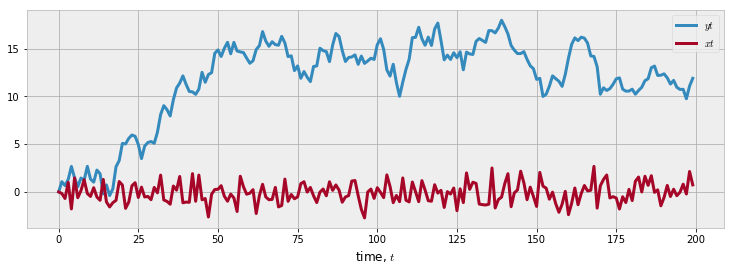

In [131]:
figsize(12.5, 4)
x_t = np.random.normal(0, 1, 200)
x_t[0] = 0
y_t = np.zeros(200)
for i in range(1, 200):
    y_t[i] = np.random.normal(y_t[i-1], 1)
plt.plot(y_t, lw=3, label="$yt$")
plt.plot(x_t, lw=3, label="$xt$")
plt.xlabel("time, $t$")
plt.legend();

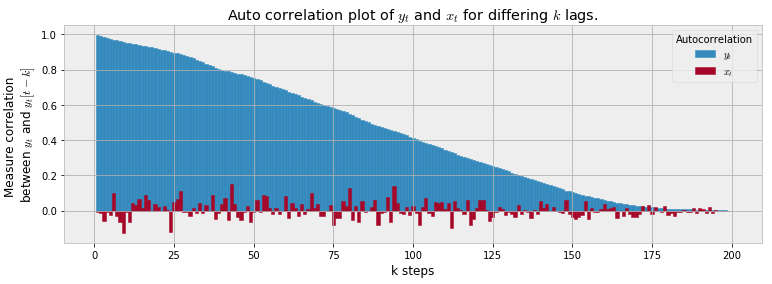

In [132]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    result = result/np.max(result)
    return result[result.size // 2:]

colors = ["#348ABD", "#A60628", "#7A68A6"]

x = np.arange(1, 200)
plt.bar(x, autocorr(y_t)[1:], width=1, label="$y_t$", 
        edgecolor=colors[0], color=colors[0])
plt.bar(x, autocorr(x_t)[1:], width=1, label="$x_t$", 
        edgecolor=colors[1], color=colors[1])

plt.legend(title="Autocorrelation")
plt.xlabel("k steps")
plt.ylabel("Measure correlation \nbetween $y_t$ and $y_t[t-k]$")
plt.title("Auto correlation plot of $y_t$ and $x_t$ for differing $k$ lags.");

By the nature of the MCMC algorithm, the returned samples exhibit autocorrelation (this is because of the step *from your current position, move to a position near you*)

A chain that is exploring the space well will exhibit very high autocorrelation. 

#### Thinning

Many post-processing algorithms require samples to be *independent* of each other. This can be solved, or at least reduced, by only returning to the user every nth sample, thus removing some autocorrelation. Below we perform an autocorrelation plot for $y_t$, with differing levels of thinning.

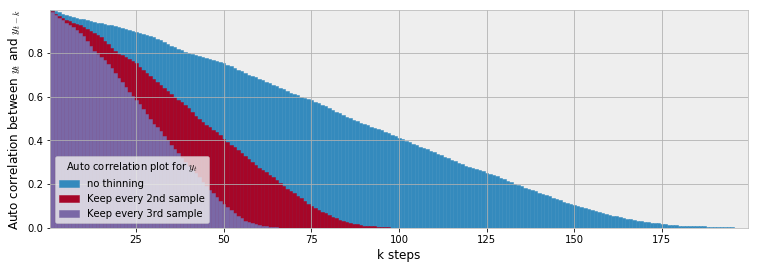

In [133]:
xmax = 200
x = np.arange(1, xmax)

thinning_2 = autocorr(y_t[::2])[1:]
thinning_3 = autocorr(y_t[::3])[1:]

plt.bar(x, autocorr(y_t)[1:xmax], edgecolor=colors[0], 
        color=colors[0], width=1, label="no thinning")
plt.bar(x[:thinning_2.size], thinning_2, edgecolor=colors[1], 
        color=colors[1], width=1, label="Keep every 2nd sample")
plt.bar(x[:thinning_3.size], thinning_3, edgecolor=colors[2], 
        color=colors[2], width=1, label="Keep every 3rd sample")

plt.autoscale(tight=True)
plt.legend(title="Auto correlation plot for $y_t$", loc="lower left")
plt.ylabel("Auto correlation between $y_t$ and $y_{t-k}$")
plt.xlabel("k steps");

With more thinning, the autocorrelation drops quicker. There is a tradeoff though: higher thinning requires more MCMC iterations to achieve the same number of returned samples

What is a good amount of thinning? The returned samples will always exhibit some autocorrelation, regardless of how much thinning is done. So long as the autocorrelation tends to zero, you are probably ok. Typically thinning of more than 10 is unnecessary.

#### pymc3.plots

The pymc3.plots module contains a few different plotting functions that you might find useful. You simply pass a *trace* returned from sampling as well as a list, *varnames*, of the variables that you are interested in. This module can provide you with plots of autocorrelation and the posterior distributions of each variable and their traces, among others.

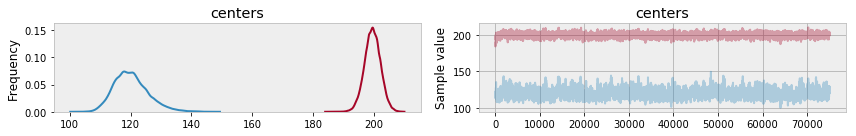

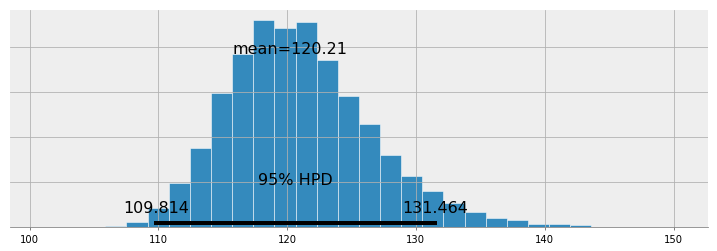

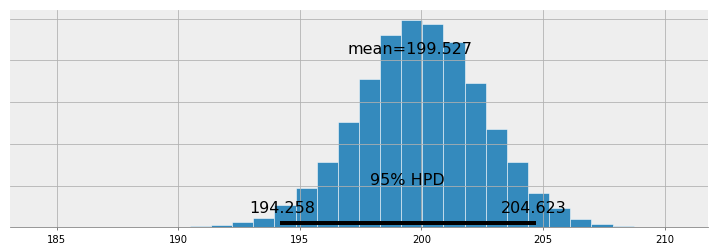

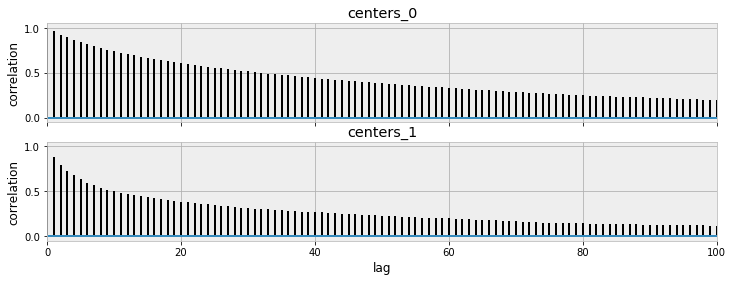

In [135]:
pm.plots.traceplot(trace=trace, varnames=["centers"])
pm.plots.plot_posterior(trace=trace["centers"][:,0])
pm.plots.plot_posterior(trace=trace["centers"][:,1])
pm.plots.autocorrplot(trace=trace, varnames=["centers"]);

The first plot gives us the posterior density of each unknown in the *centers* variable as well as the *trace* of each. 

The second plotting function(s) provides us with a histogram of the samples with a few added features. The ext overlay in the center shows us the posterior mean, which is a good summary of posterior. The inverval marked by the horizontal black line overlay represents the 95% credible interval, sometimes called the *highest posterior interval* (!= 95% confidence interval)

In [73]:
from IPython.core.display import HTML

def css_styling():
    styles = open("custom.css", "r").read()
    return HTML(styles)
css_styling()

%matplotlib inline
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pymc3 as pm
from IPython.core.pylabtools import figsize